<a href="https://colab.research.google.com/github/BakedBel/CodigosProyecto/blob/main/Paganin_Method_GeneralCode_connotas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import t
import sympy as sym
from sklearn.metrics import r2_score
from scipy.special import erf
plt.rcParams['font.family']='serif'

8.641025641025641e-09


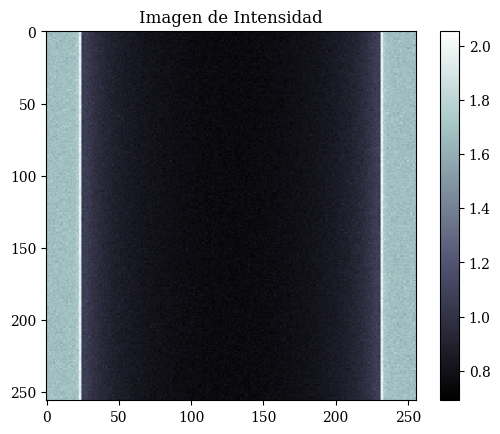

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load projection data from file. It is a 250 micro thick Teflon plate. Note
# that this data is already flatfield-corrected!

#proj = np.rot90(np.genfromtxt('RAW.txt'),1)
#proj = np.load('proj.npy')
Sample = np.genfromtxt("INLINE_solido_4mm_exactos.txt")
FF = np.genfromtxt("inline_FF15.txt") #Flat Field Correction


#Corr=np.genfromtxt("PP-PMMA-Cylinder-OD-4-mm.txt")
data3 = np.transpose(np.genfromtxt("CilindroSolido.txt"))
#Corr = ((Sample/FF) -0.98)/(1-0.98)+0.033
#Corr = np.transpose(lab)


prom=np.mean(data3,axis=1)
promt = prom.T
background_exp=[]
b1 = promt[0:10]
b2 = promt[240:250]
background_exp.append(b1)
background_exp.append(b2)
Corr = data3/np.mean(background_exp)


# Look at the data. You can see the edge-enhanced borders at the transition
# from Teflon to air. In addition, the absorbing properties of the Teflon plate
# are visible. Note that the background-values are around 1.

plt.figure()
plt.title('Imagen de Intensidad')
plt.imshow(Corr, cmap='bone', interpolation='none')
plt.colorbar()

# Also plot a line profile through the middle row.

def PI(name):
    P=np.zeros(256)

    for i in range(len(name)):
        P=P+name[i,:]
    mean=P/len(name)
    return mean

plt.figure()


#plt.plot(proj[proj.shape[0]//2][:])



# The parameters of the setup that influence the image formation process are
# specified below.

#pixel_size = .964e-6
#distance = 8.57e-3

pixel_size = 55e-6
distance = 1.2 #objeto detector

#mu = 691.
#delta = 2.6e-6

# As Paganin assumes a single material which has to be know beforehand, we look
# up the absorption index and the decrement of the real part of the complex
# refractive index in some database for the given energy. I do that for you.

mu = 0.39 * 100 #materiales de los que quiero recuperar fase
delta = 3.37e-7           #materiales de los que quiero recuperar fase
E = 17.257

#E = 4
#mu = 295.
#delta = 3.91e-9

gamma = delta/mu #delta/mu
print(gamma)
E_J=E*1.6*(10**(-16)) #E en julios
h=10**(-34)
c=3*(10**(8))
k=E_J/(h*c)


Text(0, 0.5, 'Phase Counts')

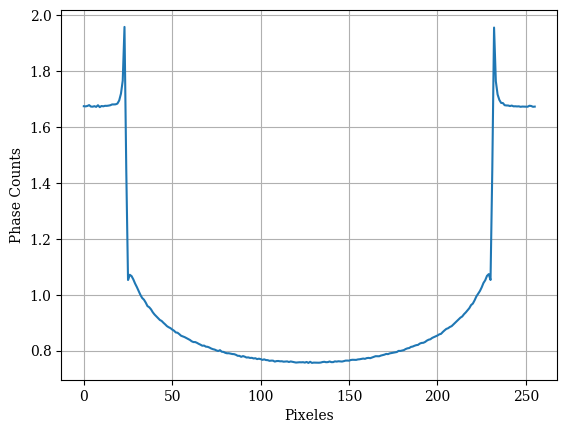

In [ ]:
mean = PI(Corr)
plt.plot(mean)
plt.grid()
plt.xlabel("Pixeles")
plt.ylabel("Phase Counts")

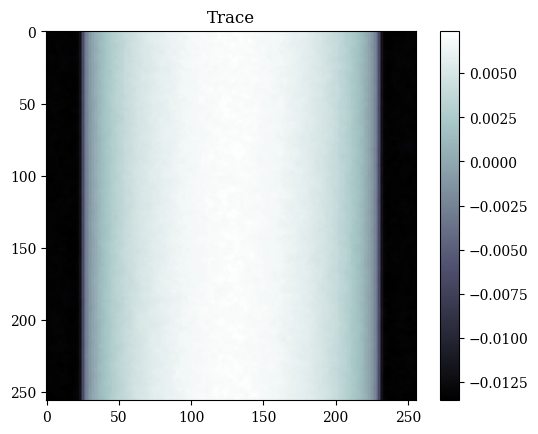

In [ ]:
# I help you with creating the frequencies that correspond to the different
# parts of the Fourier image according to our convention.

v = 2. * np.pi * np.fft.fftfreq(Corr.shape[0], d=pixel_size)
u = 2. * np.pi * np.fft.fftfreq(Corr.shape[1], d=pixel_size)
ky, kx = np.meshgrid(v, u, indexing='ij')

# Build the Paganin kernel. Its representation was discussed in the lecture.
w = pixel_size
discrete_space = -2*(np.cos(w*kx)+ np.cos(w*ky)-2)/w**2

#New Approximation

ApproxTerm = (1/12)*(w**(2))*(kx**4 + ky**4)


PaganinPro = (1/(1 - distance*(delta/mu)*(-(kx**2 + ky**2) + ApproxTerm) ))
PaganinD = (1/(distance*(delta/mu)*(kx**2 + ky**2) + 1)) #Paganin discreto

Paganin = (1/(distance*(delta/mu)*(discrete_space) + 1)) #Paganin continuo

# Recover the thickness from the projection by applying the Paganin kernel onto
# the intensity measurement.


traceD = np.multiply(np.divide(-1, mu), np.log(np.fft.ifft2(np.multiply(PaganinD, np.fft.fft2(Corr)))))

trace = np.multiply(np.divide(-1, mu), np.log(np.fft.ifft2(np.multiply(Paganin, np.fft.fft2(Corr)))))#sirve para recuperar la fase importante!!

tracePro = np.multiply(np.divide(-1, mu), np.log(np.fft.ifft2(np.multiply(PaganinPro, np.fft.fft2(Corr)))))

# Plot the recovered thickness of the sample in microns. Also plot a line
# through the center row of the trace. Check if the retrieved thickness matches
# the stated thickness in the beginning of our exercise.
#traceN=(trace-np.min(trace))/(np.max(trace)-np.min(trace))
plt.figure()
plt.title('Trace')
#plt.imshow(np.real(traceN), cmap='bone', interpolation='none')
#plt.imshow(np.real(trace), cmap='bone', interpolation='none')
plt.imshow(np.real(traceD), cmap='bone', interpolation='none')
plt.colorbar()
#plt.savefig('SAMPLE_1e8_events.png')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


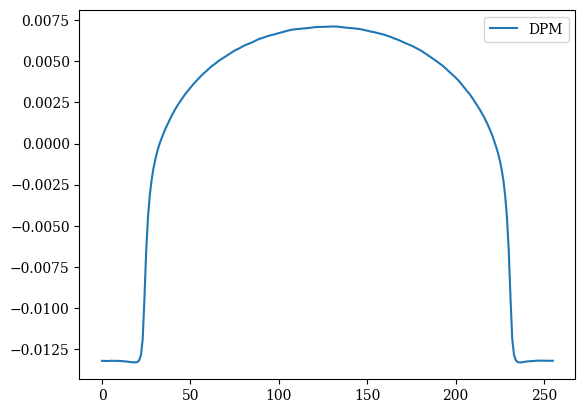

In [ ]:
#plt.figure()
#plt.plot((trace[trace.shape[0]//2][:])*np.power(10, 6))
mean1 = PI(trace)
mean2 = PI(tracePro)
mean3 = PI(traceD)
#plt.plot(mean1, label = "GPM")
#plt.plot(mean2, label = "GPM-2")
plt.plot(mean3, label = "DPM")
plt.legend()
plt.show()

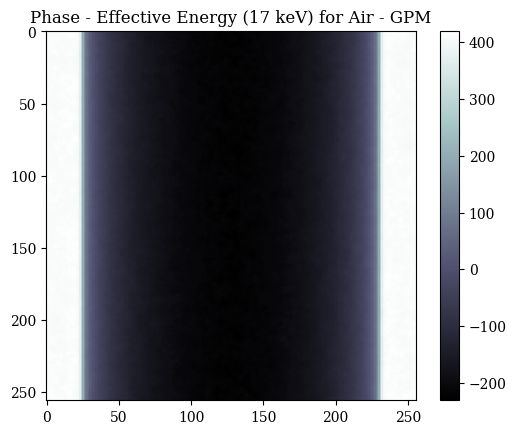

In [ ]:
Phase = -k*delta*trace#Continuo #ecuaciones beer-lambert
Phase2 = -k*delta*tracePro#Aprox
Phase3 = -k*delta*traceD#Discreto
plt.figure()
plt.title('Phase - Effective Energy (17 keV) for Air - GPM')
plt.imshow(np.real(Phase), cmap='bone', interpolation='none')
plt.colorbar()
#plt.savefig('Continuo_PM.png')
#np.savetxt("PM_Continuo.txt",np.real(Phase))
np.savetxt('PM_Discreto__Various_Mat_AIR.txt',np.real(Phase3))
#np.savetxt('PM_Aprox.txt',np.real(Phase2))

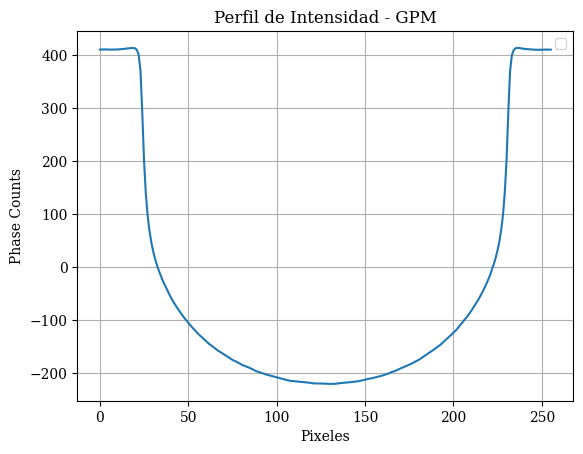

In [ ]:
PM = PI(Phase)
PM2 = PI(Phase2)
PM3 = PI(Phase3)

plt.plot(PM3)
#plt.plot(PM2, label = "GPM-2")
plt.grid()
plt.xlabel("Pixeles")
plt.ylabel("Phase Counts")
plt.legend()
plt.title("Perfil de Intensidad - GPM")
plt.show()

In [ ]:
#A = PM - PM2
#plt.plot(abs(A))

# **Calculo FWHM y CNR**

In [ ]:
def PI2(name):
    P=np.zeros(256)
    for i in range(len(name)):
        P=P+name[i,:]
    mean=P/len(name)
    return mean
def PI(name,inicial,final,h,y):
    P=np.zeros(y-h)
    for i in range(inicial,final):
        P=P+name[i,h:y]
    mean=P/(final-inicial)
    return mean

def func(x, A, n, m, b):
    k = A*erf((x-n)/(np.sqrt(2)*b))+m
    return k
def derfunc(x, A, n, b):
    k=A*np.sqrt(2/np.pi)*np.exp(-(x-n)**2/(2*b**2))/b
    return k
def func2(x,A,B):
    y = A/x + B
    return y
def exponential(x,a,b):
    y = a*np.exp(-x * b)
    return y
def CNR2(Sam_mean,BKG_mean,Sigma_B):
    return abs(Sam_mean - BKG_mean)/Sigma_B

In [ ]:
#FWHM inline and raw image
#F = np.genfromtxt('FF.txt')
#SAMP = np.genfromtxt('SAMP.txt')
phaseC = np.genfromtxt("PM_Discreto__Various_Mat_AIR.txt")

In [ ]:
nameC = phaseC

ColI=0
ColF=60
x=np.arange(ColI,ColF,1)
#guess=[0.3,80,0.1,10]
res_pC, cov_pC = curve_fit(func, x, PI(nameC,0,256,ColI,ColF))

yfitC= func(x,*res_pC)
dyfitC= derfunc(x, res_pC[0], res_pC[1], res_pC[3])
print(PI(nameC,0,256,ColI,ColF).shape)
r_score_fitC = r2_score(PI(nameC,0,256,ColI,ColF),yfitC)


r_score_fitC

(60,)


0.9789142196206839

In [ ]:
#Calculo del CNR para CPM
BKG1 = np.real(Phase)[:,50:80] #background
BKG2 = np.real(Phase)[:,170:200]#background
BKG = np.concatenate((BKG1,BKG2), axis = 1)
BKG_mean = np.mean(BKG)
Sigma_B = np.std(BKG)

Sam = np.real(Phase)[:,110:140]
Sam_mean = np.mean(Sam)
CNRC = CNR2(Sam_mean,BKG_mean,Sigma_B)
CNRC

2.879145066350619

In [ ]:
#Calculo del CNR para GPM-2
BKG1A = np.real(Phase2)[:,50:80]
BKG2A = np.real(Phase2)[:,170:200]
BKGA = np.concatenate((BKG1A,BKG2A), axis = 1)
BKGA_mean = np.mean(BKGA)
Sigma_BA = np.std(BKGA)

SamA = np.real(Phase2)[:,110:140]
Sam_meanA = np.mean(SamA)

CNRA = CNR2(Sam_meanA,BKGA_mean,Sigma_BA)
CNRA

2.8773847604182574

In [ ]:
#Calculo del CNR para DPM
DBKG1 = np.real(Phase3)[:,0:5]
DBKG2 = np.real(Phase3)[:,250:255]
DBKG = np.concatenate((DBKG1,DBKG2), axis = 1)
DBKG_mean = np.mean(DBKG)
DSigma_B = np.std(DBKG)

DSam = np.real(Phase)[:,100:150]
DSam_mean = np.mean(Sam)
CNRD = CNR2(DSam_mean,DBKG_mean,DSigma_B)
CNRD

503.803652537394

In [ ]:
FWHMC=2*np.sqrt(2*np.log(2))*res_pC[3]
sigma_FWHMC=2*np.sqrt(2*np.log(2))*cov_pC[3][3]

#sigma_SP=SP*np.sqrt((sigma_FWHP/FWHP)**2+(0.05/RT)**2)
print(FWHMC, sigma_FWHMC)

-64.12067687931874 inf


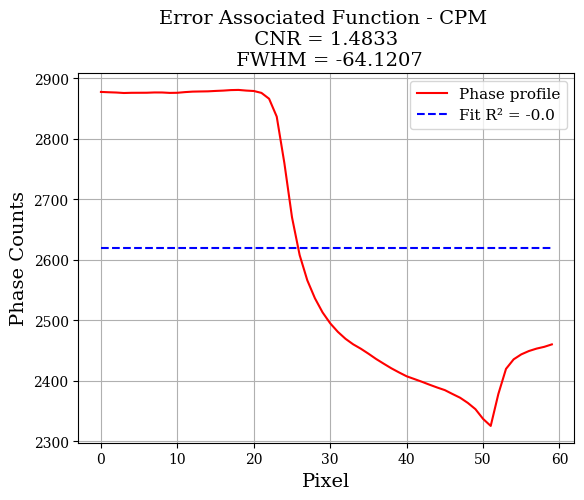

In [ ]:
plt.plot(x,PI(nameC,0,256,ColI,ColF), label="Phase profile", color="red")
plt.plot(x, yfitC, '--', label="Fit R² = {}".format(round(r_score_fitC,6)), color="blue")
plt.title("Error Associated Function - CPM \n CNR = {} \n FWHM = {}".format(round(CNRC,4), round(FWHMC,4)),fontsize=14)
plt.ylabel("Phase Counts",fontsize=14)
plt.xlabel("Pixel",fontsize=14)
plt.grid()
plt.legend(loc='best', fontsize=11)
plt.savefig('Error_function_CPM.png')

In [ ]:
plt.plot(x,PI(nameA,0,256,ColI,ColF), label="Phase profile", color="red")
plt.plot(x, yfitA, '--', label="Fit R² = {}".format(round(r_score_fitA,6)), color="blue")
plt.title("Error Associated Function - APM \n CNR = {} \n FWHM = {}".format(round(CNRA,4), round(FWHMA,4)),fontsize=14)
plt.ylabel("Phase Counts",fontsize=14)
plt.xlabel("Pixel",fontsize=14)
plt.grid()
plt.legend(loc='best', fontsize=11)
plt.savefig('Error_function_APM.png')

NameError: name 'nameA' is not defined

In [ ]:
plt.plot(x,PI(nameA,0,256,ColI,ColF), label="Phase profile", color="red")
plt.plot(x, yfitD, '--', label="Fit R² = {}".format(round(r_score_fitD,6)), color="blue")
plt.title("Error Associated Function - DPM \n CNR = {} \n FWHM = {}".format(round(CNRD,4), round(FWHMD,4)),fontsize=14)
plt.ylabel("Phase Counts",fontsize=14)
plt.xlabel("Pixel",fontsize=14)
plt.grid()
plt.legend(loc='best', fontsize=11)
plt.savefig('Error_function_DPM.png')

In [ ]:
fig, axes = plt.subplots()
plt.plot(x, -dyfitC, '--', color="green", label= '$\partial$/$\partial_{x}$ ERF')

plt.title("Differential error function",fontsize=14)
plt.ylabel("Intensity",fontsize=14)
plt.xlabel("Pixel",fontsize=14)
plt.grid()
plt.legend(loc='best', fontsize=11)
#plt.savefig('differencial_error_function.png')

In [ ]:
print(np.linspace(1000,30000,30))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -5.619325526239197e-20, -5.844098547288765e-20, -6.068871568338334e-20, -6.293644589387902e-20, -6.518417610437469e-20, -6.743190631487037e-20, -6.967963652536605e-20, -7.192736673586173e-20, -7.417509694635741e-20, -7.64228271568531e-20, -7.867055736734878e-20, -8.091828757784444e-20, -8.316601778834012e-20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


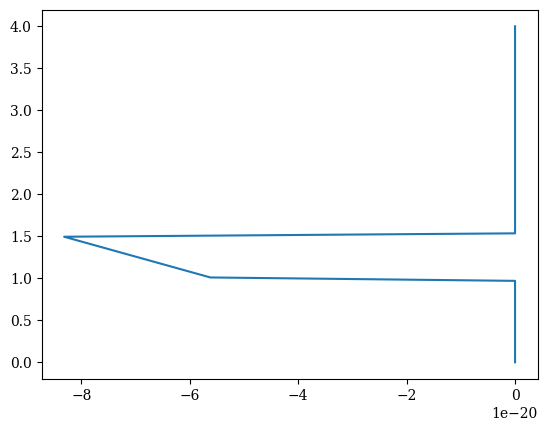

In [ ]:
r=np.linspace(0,4,100)

r_0 = 1
lambda_0 = 4E-9
I_0 = 0.001
epsilon_0 = 8.854E-12
mu_0 = 1.256E-6

def E(r):
  lista=[]
  for i in range(len(r)):
    if r[i]<r_0 or r[i]>(3/2)*r_0:
      lista.append(0)
    else:
      valor = -(lambda_0/2*np.pi*epsilon_0*r[i])
      lista.append(valor)
  return lista

def B(r):
  lista=[]
  for i in range(len(r)):
    if r[i]<r_0 or r[i]>(3/2)*r_0:
      lista.append(0)
    else:
      valor = -(mu_0*I_0/2*np.pi*r[i])
      lista.append(valor)
  return lista

E_graph = E(r)
B_graph = B(r)

print(E_graph)

plt.plot(E_graph,r)
#plt.plot(B_graph,r)